# Personal Information
Name: **Nihal Boukhoubza**

StudentID: **14890909**

Email: [**Nihal.boukhoubza@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **23.03.2025**

Github: **https://github.com/NihalBou14/Scriptie**

# Data Context

**Structure of the Primary Database Tables (shopping.db)**

The primary database consists of six tables, each containing a distinct number of records:

- **Customer**: 190 rows  
- **Store**: 64 rows  
- **Product**: 32 rows  
- **ShoppingList**: 492 rows  
- **Purchase**: 509 rows  
- **Inventory**: 829 rows  
These tables include primary keys and foreign key relationships, ensuring referential integrity within the database schema.

**Dataset**

The dataset is derived from IPython log files, capturing SQL query submissions from students. The logs include the following key components:

- **Query**: The raw SQL query text submitted by the student, such as:  
  `query3_2`, `query3_3`, `query3_4`, `query3_5`, `query4_3`, `query4_4`, `query4_5`, `query4_6`, `query4_7`  
- **Timestamp**: The exact time when the query was submitted (e.g., `Tue, 08 Dec 2020 11:14:15`). 

The dataset contains SQL queries from 41 students in week 3 and 33 students in week 4.
The initial count of SQL queries was 4,347, distributed as follows:

- **Week 3**: 1,729 queries  
- **Week 4**: 2,618 queries  
This dataset provides valuable insights into student engagement, query complexity, and potential errors encountered during SQL execution.

# Data Description


**Imports**

In [6]:
import os
import numpy as np
import pandas as pd
import sqlite3
import pandas as pd
import re
from IPython.display import display
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import duckdb
from sklearn.ensemble import RandomForestClassifier

**Data loading**

SQlite database

In [2]:
def connect_to_database(db_path):
    return sqlite3.connect(db_path)

def get_table_names(cursor):
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    return [table[0] for table in cursor.fetchall()]

def fetch_table_data(cursor, table_name):
    cursor.execute(f"SELECT * FROM {table_name} LIMIT 20;")  # <-- Top 20
    columns = [desc[0] for desc in cursor.description]  
    rows = cursor.fetchall()  
    return pd.DataFrame(rows, columns=columns) 

def main():
    db_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/shoppingDB_sqlite.sqlite'
    conn = connect_to_database(db_path)
    cursor = conn.cursor()
    
    # Alleen data uit de 'customer' tabel ophalen
    table_name = 'customer'
    print(f"\n Data from Table: {table_name}\n")
    df = fetch_table_data(cursor, table_name)
    
    if df.empty:
        print("⚠️ This table is empty.")
    else:
        print(df.to_string(index=False)) 
    
    conn.close()


if __name__ == "__main__":
    main()



 Data from Table: customer

 cID  cName               street      city
   0   Noah            Koestraat   Utrecht
   1    Sem     Rozemarijnstraat     Breda
   2  Lucas     Oude Leliestraat Amsterdam
   3   Finn        Stationsplein     Breda
   4   Daan         Kalverstraat Amsterdam
   5   Levi       Gasthuisstraat   Utrecht
   6  Milan          Parallelweg   Utrecht
   7   Bram         Schoolstraat Eindhoven
   8   Liam        Rijsbergseweg     Breda
   9 Thomas          Parallelweg Amsterdam
  10    Sam          Langestraat   Tilburg
  11  Thijs            Koestraat   Tilburg
  12   Adam          Nieuwstraat Eindhoven
  13  James      Sint Annastraat     Breda
  14    Max            Eikenlaan   Tilburg
  15   Noud         Koningshoeve   Tilburg
  16 Julian Prins Bernhardstraat Eindhoven
  17    Dex         Kasteeldreef   Tilburg
  18   Hugo         Kasteeldreef   Tilburg
  19   Lars        Rijsbergseweg     Breda


IPython student logs

In [5]:
def open_student_file(submission_week, file_number):
    base_directory_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/VIS_data_Nihal'
    filename = f"{file_number}.py"
    
    file_path = os.path.join(base_directory_path, submission_week, filename)
    
    if not os.path.exists(file_path):
        return f"❌ Bestand niet gevonden: {file_path}"
    
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    # Laatste 20 regels
    last_20 = lines[-20:] if len(lines) >= 20 else lines
    return ''.join(last_20)

submission_week = 'submissions_week3'
file_number = 'pp14'  

file_content = open_student_file(submission_week, file_number)
print(file_content)



#[Out]# 7  189    Koen
# Sat, 28 Nov 2020 23:58:17
query3_4 = '''
    SELECT DISTINCT c.cID, c.cName
    FROM customer c, store s, purchase p
    WHERE c.cID = p.cID
    AND p.sID = s.sID
    AND s.sName = "Kumar"
    AND NOT EXISTS (SELECT *
                    FROM store s1, purchase p1
                    WHERE c.cID = p1.cID
                    AND s1.sID = p1.sID
                    AND s1.sName != "Kumar")
'''

pd.read_sql_query(query3_4, conn)
#[Out]# Empty DataFrame
#[Out]# Columns: [cID, cName]
#[Out]# Index: []




**Data clean up**

I developed a Python script to extract and clean SQL queries from log files, aiming to organize the data for better analysis. Here's a summary of the steps:

**Query Extraction:**
- Implemented the extract_queries function to read log files and extract relevant SQL queries using regex. Removed comments and unnecessary information using re.sub.

**Normalization and Filtering:**
- Normalized queries by removing extra spaces and newlines to prevent hidden duplicates.
- Filtered out empty queries, placeholders (e.g., `"PUT YOUR QUERY HERE"`), and queries containing only spaces.

**Data Collection:**
- Collected queries from .py files in the `submissions_week3` and `submissions_week4` folders.
- Stored each query’s timestamp, name, and content in a list of dictionaries.

**Data Cleaning and Deduplication:**
- Converted the list to a pandas DataFrame and removed duplicate rows.
- Excluded specific queries (`query3_5`, `query4_6`, `query4_7`) identified as experimental or irrelevant.

**Result:**
- Reduced the dataset from 4,347 to 4,236 rows.
- Final dataset includes only unique, relevant queries organized by timestamp, query name, and query content.

In [23]:
def extract_queries(file_path):
    with open(file_path, 'r') as file:
        log_content = file.read()
    log_content = re.sub(r'/\*.*?\*/', '', log_content, flags=re.DOTALL)
    pattern = r'# (\w+, \d+ \w+ \d+ \d+:\d+:\d+).*?\n.*?query(\d+_\d+) = \'\'\'(.*?)\'\'\'' 
    matches = re.findall(pattern, log_content, re.DOTALL)
    data = []
    
    for match in matches:
        timestamp = ' '.join(match[0].split(', ')[1:])
        query_name = match[1]
        query = match[2].strip()
        
        query = ' '.join(query.split())

        if query and query != 'PUT YOUR QUERY HERE' and not query.isspace() and '\\' not in query:
            data.append({'Timestamp': timestamp, 'Query Name': query_name, 'Query': query})
    
    return data

base_directory_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/VIS_data_Nihal'
folders = ['submissions_week3', 'submissions_week4']

all_queries = []
for folder in folders:
    folder_path = os.path.join(base_directory_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.py'):
            file_path = os.path.join(folder_path, file)
            queries = extract_queries(file_path)
            all_queries.extend(queries)

queries_df = pd.DataFrame(all_queries).drop_duplicates()

# Filteren op specifieke querynamen
queries_df = queries_df[~queries_df['Query Name'].isin(['3_5', '4_6', '4_7'])].reset_index(drop=True)

display(queries_df)


,Timestamp,Query Name,Query
0,28 Nov 2020 14:50:54,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin..."
1,28 Nov 2020 14:51:00,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin..."
2,28 Nov 2020 14:51:52,3_2,SELECT * FROM purchase
3,28 Nov 2020 14:52:40,3_2,"SELECT * FROM purchase WHERE data LIKE ""2018"""
4,28 Nov 2020 14:52:45,3_2,SELECT * FROM purchase WHERE data LIKE '2018'
...,...,...,...
4231,09 Dec 2020 12:40:16,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...
4232,09 Dec 2020 12:40:22,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...
4233,09 Dec 2020 12:41:07,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...
4234,09 Dec 2020 12:42:20,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...


**Data Analysis**


After the initial data cleanup, I enriched the dataset by adding additional columns to capture various aspects of the SQL queries, such as error types, query complexity metrics, and keyword usage. To achieve this, I implemented several functions to analyze queries, including counting brackets, tables, words, subqueries, and conditions in the `WHERE` clause. I also developed functions to identify invalid columns and tables, as well as to count comments within the queries.

To categorize errors, I created a function called `categorize_error` that classifies errors into syntax errors, logic errors, conceptual errors, or unknown errors based on the error message. Additionally, I implemented a `count_keywords` function to track the usage of SQL keywords like `SELECT`, `FROM`, `WHERE`, and `JOIN`, among others. Each query was executed against an SQLite database to capture errors, and the error messages were logged and categorized.

The enriched dataset now includes columns for error presence and type, counts of brackets, tables, keywords, and conditions, as well as query length, word count, and subquery count. Invalid columns and tables were also identified and counted. After combining all the data into a pandas DataFrame, I removed duplicates and filtered out irrelevant queries (3_5, 4_6, 4_7). The final dataset was exported to a CSV file for further analysis.

This process provided valuable insights into query structure and error patterns, enabling a more comprehensive analysis of common issues and query complexity.

In [35]:
def count_brackets(query):
    return query.count('(') + query.count(')')

def count_tables(query, table_list):
    return len(set(table for table in table_list if table in query.lower()))

def query_length(query):
    return len(query)

def word_count(query):
    return len(query.split())

def count_subqueries(query):
    return query.lower().count('select') - 1

def count_where_conditions(query):
    where_index = query.lower().find('where')
    if where_index == -1:
        return 0
    where_clause = query[where_index + 5:]
    return where_clause.count('and') + where_clause.count('or') + 1

def count_comments(query):
    return query.lower().count('--') + query.lower().count('/*')

def count_invalid_columns(query, valid_columns):
    query_lower = query.lower()
    columns_in_query = re.findall(r'\b\w+\.\w+\b', query_lower)
    column_names = [column.split('.')[1] for column in columns_in_query]
    valid_columns_lower = [col.lower() for col in valid_columns]
    return sum(1 for column in column_names if column not in valid_columns_lower)

def count_invalid_tables(query, valid_tables):
    query_lower = query.lower()
    tables_in_query = re.findall(r'\bfrom\s+(\w+)', query_lower, re.IGNORECASE)
    valid_tables_lower = [table.lower() for table in valid_tables]
    return sum(1 for table in tables_in_query if table not in valid_tables_lower)

def extract_queries_and_timestamps(file_path):
    with open(file_path, 'r') as file:
        log_content = file.read()
    log_content = re.sub(r'/\*.*?\*/', '', log_content, flags=re.DOTALL)
    pattern = r'# (\w+, \d+ \w+ \d+ \d+:\d+:\d+).*?\n.*?query(\d+_\d+) = \'\'\'(.*?)\'\'\'' 
    matches = re.findall(pattern, log_content, re.DOTALL)
    data = []
    table_names = ['store', 'shoppinglist', 'purchase', 'product', 'inventory', 'customer']
    valid_columns = ['cid', 'cname', 'street', 'city', 'sid', 'sname', 'pid', 'pname', 'suffix', 'quantity', 'date', 'tid', 'price', 'unit_price']
    for match in matches:
        timestamp = ' '.join(match[0].split(', ')[1:])
        query_name = match[1]
        query = match[2].strip()
        query = ' '.join(query.split())
        if query and query != 'PUT YOUR QUERY HERE' and not query.isspace() and '\\' not in query:
            bracket_count = count_brackets(query)
            table_count = count_tables(query, table_names)
            length_count = query_length(query)
            word_count_value = word_count(query)  # Renamed variable
            subquery_count = count_subqueries(query)
            comments_count = count_comments(query)
            invalid_columns_count = count_invalid_columns(query, valid_columns)
            invalid_tables_count = count_invalid_tables(query, table_names)
            where_conditions_count = count_where_conditions(query)
            data.append((timestamp, query, query_name, bracket_count, table_count, length_count, word_count_value, subquery_count, comments_count, invalid_columns_count,  invalid_tables_count, where_conditions_count))
    return data


def count_keywords(query):
    keywords = ['select', 'with', 'from', 'where', 'group by', 'join','having', 'distinct', 'order by', 'count', 'sum',  'max', 'limit', 'union', 'as', '=', '>', '<', 'like', 'in']
    keyword_counts = {keyword: query.lower().count(keyword) for keyword in keywords}
    keyword_counts['group by & having'] = 1 if 'group by' in query.lower() and 'having' in query.lower() else 0
    return keyword_counts

def categorize_error(error_message):
    if not error_message:
        return "No Error"

    error_message = error_message.lower() 

    # Syntax Errors
    syntax_keywords = [
        "syntax", "unrecognized token", "incomplete input", "no such", 
        "not found", "wrong number of arguments", "misuse of aggregate", 
        "circular reference", "you can only execute one statement at a time",
        "misuse of aliased aggregate", "row value misused"
    ]
    if any(keyword in error_message for keyword in syntax_keywords):
        return "Syntax Error"

    # Logic Errors
    logic_keywords = [
        "ambiguous column name", "sub-select returns", "selects to the left and right of", 
        "a join clause is required before on", "having clause on a non-aggregate query", 
        "in(...) element has", "table missing", "no tables specified", "foreign key constraint", 
        "constraint fails", "already exists", "has 2 values for 1 columns", "has 3 values for 1 columns", 
        "has 1 values for 2 columns"
    ]
    if any(keyword in error_message for keyword in logic_keywords):
        return "Logic Error"

    return "Unknown Error"

# Connect to an in-memory SQLite database
db_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/shoppingDB_sqlite.sqlite'  # Voeg het juiste pad toe aan je databasebestand
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Path to the main directory containing folders
base_directory_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/VIS_data_Nihal'
folders = ['submissions_week3', 'submissions_week4']

# Extract and test queries from all students
all_queries = []
for folder in folders:
    folder_path = os.path.join(base_directory_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.py'):
            file_path = os.path.join(folder_path, file)
            extracted_data = extract_queries_and_timestamps(file_path)
            for timestamp, query, query_name, bracket_count, table_count, length_count, word_count_value, subquery_count, comments_count, invalid_columns_count,  invalid_tables_count, where_conditions_count in extracted_data:
                error_message = ""
                try:
                    cursor.execute(query)
                    conn.commit()
                except Exception as e:
                    error_message = str(e)
                keyword_counts = count_keywords(query)
                all_queries.append({
                    'Folder': folder,
                    'File': file,
                    'Timestamp': timestamp,
                    'Query Name': query_name,
                    'Query': query,
                    'Contains error': 1 if error_message else 0,
                    'Error Type': categorize_error(error_message),
                    'Error Message': error_message,
                    'Bracket Count': bracket_count,
                    'Table Count': table_count,
                    'Where Count': keyword_counts['where'],
                    'Group By Count': keyword_counts['group by'],
                    'Select Count': keyword_counts['select'],
                    'From Count': keyword_counts['from'],
                    'Join Count': keyword_counts['join'],
                    'Having count': keyword_counts['having'],
                    'Distinct count': keyword_counts['distinct'],
                    'Group By & Having': keyword_counts['group by & having'],
                    'Order by count': keyword_counts['order by'],
                    'Count Count': keyword_counts['count'],
                    'Sum Count': keyword_counts['sum'],
                    'Max Count': keyword_counts['max'],
                    'Limit Count': keyword_counts['limit'],
                    'Union Count': keyword_counts['union'],
                    'As Count': keyword_counts['as'],
                    '= Count': keyword_counts['='],
                    '< Count': keyword_counts['<'],
                    '> Count': keyword_counts['>'],
                    'Like Count': keyword_counts['like'],
                    'In Count': keyword_counts['in'],
                    'with Count': keyword_counts['with'],
                    'Length Count': length_count, 
                    'Word Count': word_count_value, 
                    'Subquery count': subquery_count, 
                    'Comments Count': comments_count, 
                    'Invalid Column Count':invalid_columns_count,  
                    'Invalid Tables Count': invalid_tables_count, 
                    'Where Condition Count': where_conditions_count
                })


queries_df = pd.DataFrame(all_queries).drop_duplicates()
queries_df = queries_df[~queries_df['Query Name'].isin(['3_5', '4_6', '4_7'])].reset_index(drop=True)

display(queries_df)

csv_output_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/query_analysis2.csv'
queries_df.to_csv(csv_output_path, index=False, encoding='utf-8')
print(f"CSV file successfully saved at: {csv_output_path}")

# Close the database connection
conn.close()

,Folder,File,Timestamp,Query Name,Query,Contains error,Error Type,Error Message,Bracket Count,Table Count,...,Like Count,In Count,with Count,Length Count,Word Count,Subquery count,Comments Count,Invalid Column Count,Invalid Tables Count,Where Condition Count
0,submissions_week3,pp1.py,28 Nov 2020 14:50:54,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0,No Error,,0,3,...,0,1,0,128,22,0,0,0,0,1
1,submissions_week3,pp1.py,28 Nov 2020 14:51:00,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0,No Error,,0,3,...,0,1,0,128,22,0,0,0,0,1
2,submissions_week3,pp1.py,28 Nov 2020 14:51:52,3_2,SELECT * FROM purchase,0,No Error,,0,1,...,0,0,0,22,4,0,0,0,0,0
3,submissions_week3,pp1.py,28 Nov 2020 14:52:40,3_2,"SELECT * FROM purchase WHERE data LIKE ""2018""",1,Syntax Error,no such column: data,0,1,...,1,0,0,45,8,0,0,0,0,1
4,submissions_week3,pp1.py,28 Nov 2020 14:52:45,3_2,SELECT * FROM purchase WHERE data LIKE '2018',1,Syntax Error,no such column: data,0,1,...,1,0,0,45,8,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,submissions_week4,pp9.py,09 Dec 2020 12:40:16,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,1,...,0,1,1,245,40,2,0,2,0,0
4232,submissions_week4,pp9.py,09 Dec 2020 12:40:22,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,1,...,0,1,1,245,40,2,0,2,0,0
4233,submissions_week4,pp9.py,09 Dec 2020 12:41:07,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,1,Logic Error,sub-select returns 3 columns - expected 1,14,2,...,0,2,1,287,47,3,0,2,0,1
4234,submissions_week4,pp9.py,09 Dec 2020 12:42:20,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,2,...,0,1,1,282,41,2,0,2,0,1


CSV file successfully saved at: C:/Users/NihalBoukhoubza/OneDrive/Scriptie/query_analysis2.csv


To gain a better understanding of the data, I analyzed how much time each student spent on each question by adding two new columns: one representing the time spent in seconds and the other in minutes. I achieved this by converting the Timestamp column to datetime objects and calculating the time difference between the first and last execution of each query for every student. This was done by grouping the data by Folder, File, and Query Name and using a transformation to compute the time spent. Additionally, I calculated the number of executions for each query by counting the occurrences of each combination of Folder, File, and Query Name. These execution counts were then merged back into the DataFrame. Finally, I saved the updated DataFrame, now including the time spent and execution counts, as a CSV file for further analysis. This enrichment provides deeper insights into the effort and engagement of students with each query.

In [70]:
def calculate_time_spent(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d %b %Y %H:%M:%S')
    df['Time Spent (seconds)'] = df.groupby(['Folder', 'File', 'Query Name'])['Timestamp'] \
        .transform(lambda x: (x.max() - x.min()).total_seconds())

    df['Time Spent (minutes)'] = df['Time Spent (seconds)'] / 60

    execution_counts = df.groupby(['Folder', 'File', 'Query Name']).size().reset_index(name='Execution Count')

    df = df.merge(execution_counts, on=['Folder', 'File', 'Query Name'], how='left')
    
    return df

queries_df = calculate_time_spent(queries_df)

display(queries_df)

csv_output_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/query_analysis_with_time_and_execution_count.csv'
queries_df.to_csv(csv_output_path, index=False, encoding='utf-8')
print(f"CSV file successfully saved at: {csv_output_path}")

,Folder,File,Timestamp,Query Name,Query,Contains error,Error Type,Error Message,Bracket Count,Table Count,...,Length Count,Word Count,Subquery count,Comments Count,Invalid Column Count,Invalid Tables Count,Where Condition Count,Time Spent (seconds),Time Spent (minutes),Execution Count
0,submissions_week3,pp1.py,2020-11-28 14:50:54,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0,No Error,,0,3,...,128,22,0,0,0,0,1,71721.0,1195.350000,17
1,submissions_week3,pp1.py,2020-11-28 14:51:00,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0,No Error,,0,3,...,128,22,0,0,0,0,1,71721.0,1195.350000,17
2,submissions_week3,pp1.py,2020-11-28 14:51:52,3_2,SELECT * FROM purchase,0,No Error,,0,1,...,22,4,0,0,0,0,0,71721.0,1195.350000,17
3,submissions_week3,pp1.py,2020-11-28 14:52:40,3_2,"SELECT * FROM purchase WHERE data LIKE ""2018""",1,Syntax Error,no such column: data,0,1,...,45,8,0,0,0,0,1,71721.0,1195.350000,17
4,submissions_week3,pp1.py,2020-11-28 14:52:45,3_2,SELECT * FROM purchase WHERE data LIKE '2018',1,Syntax Error,no such column: data,0,1,...,45,8,0,0,0,0,1,71721.0,1195.350000,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,submissions_week4,pp9.py,2020-12-09 12:40:16,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,1,...,245,40,2,0,2,0,0,1963.0,32.716667,35
4232,submissions_week4,pp9.py,2020-12-09 12:40:22,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,1,...,245,40,2,0,2,0,0,1963.0,32.716667,35
4233,submissions_week4,pp9.py,2020-12-09 12:41:07,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,1,Logic Error,sub-select returns 3 columns - expected 1,14,2,...,287,47,3,0,2,0,1,1963.0,32.716667,35
4234,submissions_week4,pp9.py,2020-12-09 12:42:20,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,2,...,282,41,2,0,2,0,1,1963.0,32.716667,35


CSV file successfully saved at: C:/Users/NihalBoukhoubza/OneDrive/Scriptie/query_analysis_with_time_and_execution_count.csv


To better understand which questions may have been more challenging, I first analyzed the total number of queries executed per question. This was achieved by grouping the data by Query Name and counting the number of queries for each question. The results showed that questions 4.3, 4.4, and 4.5 had the highest number of queries, indicating potentially higher complexity or difficulty.

Next, I examined the distribution of query executions across individual student files to identify any outliers. By grouping the data by both Query Name and File, I was able to see how many times each student executed a specific query. This revealed variations in the number of attempts per student, with some files showing significantly higher or lower execution counts compared to the average. This information is valuable for identifying patterns in student behavior and pinpointing questions that may have caused more frequent retries or confusion.

Finally, I analyzed the time spent on each query by extracting the distinct Time Spent (seconds) for each Query Name and File. This allowed me to see how much time students dedicated to solving each question. Some queries showed substantial time investments, suggesting they were more time-consuming or required deeper engagement. This data will help refine my scoring system and guide further analysis into which questions posed the greatest challenges.

In [85]:
Query_Overview = duckdb.query(
'SELECT "Query Name", count(Query) as Amount_Of_Queries FROM queries_df group by "Query Name" order by "Query Name" ').to_df()

print(Query_Overview)


  Query Name  Amount_Of_Queries
0        3_2                625
1        3_3                669
2        3_4                399
3        4_3                926
4        4_4                827
5        4_5                790


In [86]:
Query_Amount_Overview = duckdb.query(
'SELECT "Query Name", File, count(Query) as Amount_Of_Queries FROM queries_df group by "Query Name", File order by "Query Name" ').to_df()

print(Query_Amount_Overview )


    Query Name     File  Amount_Of_Queries
0          3_2   pp1.py                 17
1          3_2  pp14.py                 31
2          3_2  pp33.py                 11
3          3_2   pp4.py                  2
4          3_2  pp19.py                 17
..         ...      ...                ...
208        4_5  pp43.py                 16
209        4_5  pp46.py                  1
210        4_5  pp17.py                 20
211        4_5  pp20.py                  3
212        4_5  pp47.py                 19

[213 rows x 3 columns]


In [87]:
Query_time_overview = duckdb.query(
'SELECT distinct "Query Name", File, "Time Spent (seconds)" FROM queries_df  ').to_df()

print(Query_time_overview)


    Query Name     File  Time Spent (seconds)
0          3_4  pp12.py                8407.0
1          3_2  pp14.py                3114.0
2          3_4  pp17.py                 541.0
3          3_4  pp31.py                   0.0
4          3_3  pp33.py                 829.0
..         ...      ...                   ...
208        4_5  pp21.py              174561.0
209        4_5   pp3.py                 140.0
210        4_4  pp34.py               17129.0
211        4_3  pp40.py                3925.0
212        4_5  pp40.py                1914.0

[213 rows x 3 columns]


**Boxplot 1:**
To even better understand and analyze the time students spent on each question, as well as to identify potential outliers, I created a boxplot. This visualization provides a clear overview of the distribution of time spent (in seconds) across different questions (Query Name). Each boxplot represents a specific question, and the y-axis shows the time spent by students to complete that question. The boxplot allows us to observe the variation in time spent, including the median, interquartile range (IQR), and any outliers.

It’s evident that some questions (e.g., 3.2 and 4.3) have much wider IQRs and more extreme outliers than others, suggesting higher variability in how long students took. This could indicate differences in question complexity, student understanding, or even distractions. On the other hand, questions like 3.4 or 4.5 show tighter distributions, meaning students spent more similar amounts of time on them.

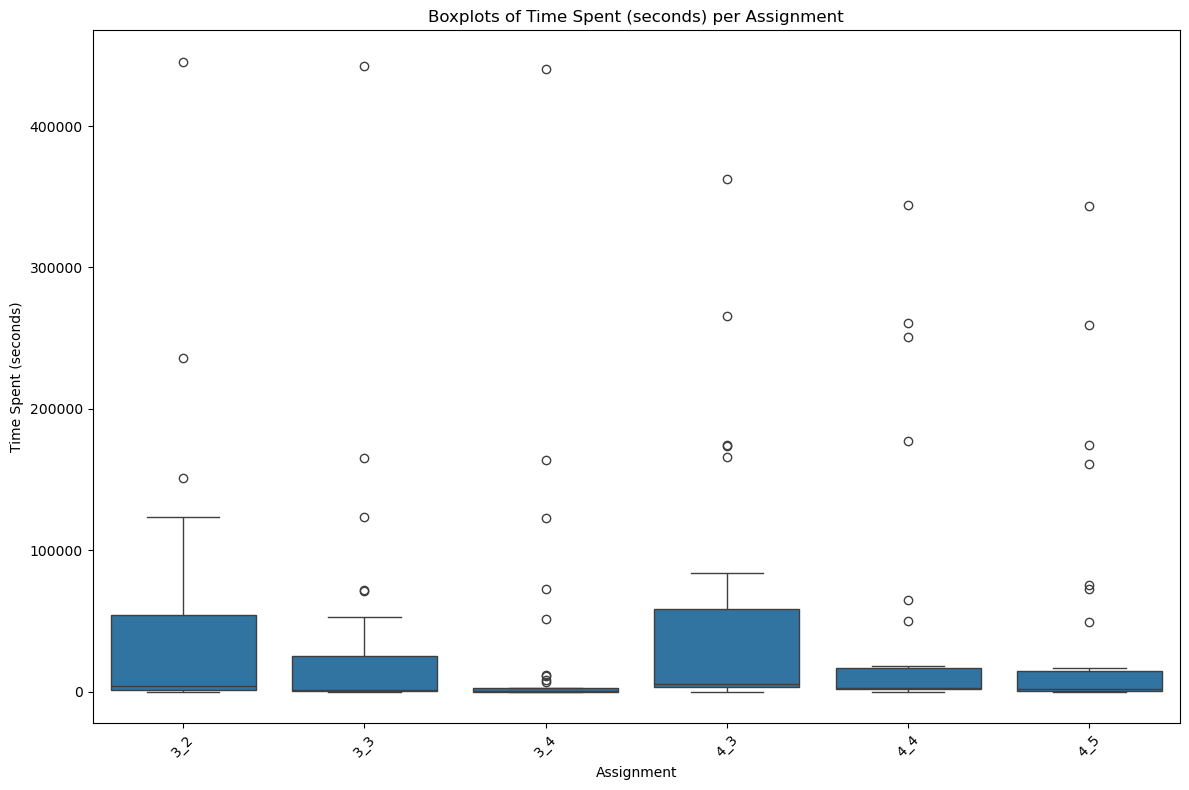

In [131]:
sorted_query_names = sorted(Query_time_overview['Query Name'].unique(), key=lambda x: [int(i) for i in x.split('_')])

plt.figure(figsize=(12, 8))
sns.boxplot(
    x='Query Name',
    y='Time Spent (seconds)',
    data=Query_time_overview,
    order=sorted_query_names 
)
plt.title('Boxplots of Time Spent (seconds) per Assignment')
plt.xlabel('Assignment')
plt.ylabel('Time Spent (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [139]:
boxplot_stats = Query_time_overview.groupby('Query Name')['Time Spent (seconds)'].describe()

outlier_counts = []

for query_name, group in Query_time_overview.groupby('Query Name'):
    q1 = group['Time Spent (seconds)'].quantile(0.25)
    q3 = group['Time Spent (seconds)'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = group[(group['Time Spent (seconds)'] < lower_bound) | (group['Time Spent (seconds)'] > upper_bound)]
    
    outlier_counts.append({
        'Query Name': query_name,
        'Outlier Count': len(outliers),
        'Outlier %': (len(outliers) / len(group)) * 100
    })

outlier_df = pd.DataFrame(outlier_counts)

boxplot_stats = boxplot_stats.reset_index()

combined_df = pd.merge(boxplot_stats, outlier_df, on='Query Name')

combined_df = combined_df.set_index('Query Name').loc[sorted_query_names].reset_index()

pd.set_option('display.float_format', '{:.2f}'.format)
display(combined_df)


,Query Name,count,mean,std,min,25%,50%,75%,max,Outlier Count,Outlier %
0,3_2,41.00,41125.59,81803.50,0.00,1016.00,4165.00,54038.00,445407.00,3,7.32
1,3_3,41.00,28879.90,75315.03,0.00,389.00,1006.00,25395.00,442374.00,5,12.20
2,3_4,40.00,22663.55,75721.85,0.00,52.00,546.50,2436.25,440384.00,9,22.50
3,4_3,32.00,48225.00,87646.69,6.00,3752.50,5496.00,58693.00,362707.00,5,15.62
4,4_4,29.00,43141.93,91489.58,0.00,1937.00,3018.00,17129.00,343980.00,6,20.69
5,4_5,30.00,39996.23,84672.72,0.00,414.50,1954.00,14806.75,343424.00,7,23.33


In [140]:
outliers_dict = {}

for query_name, group in Query_time_overview.groupby('Query Name'):
    q1 = group['Time Spent (seconds)'].quantile(0.25)
    q3 = group['Time Spent (seconds)'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = group[(group['Time Spent (seconds)'] < lower_bound) | (group['Time Spent (seconds)'] > upper_bound)]

    outliers_dict[query_name] = outliers.reset_index(drop=True)

display(outliers_dict['3_2'])


,Query Name,File,Time Spent (seconds)
0,3_2,pp32.py,236246.00
1,3_2,pp43.py,445407.00
2,3_2,pp18.py,151203.00


**Stacked Bar Chart 1:**
Below, I have created a stacked bar chart that visually represents the distribution of different error types across each assignment (Query Name). Each bar corresponds to a specific assignment, and the segments within the bar indicate the proportion of each error type. This chart provides a clear overview of which assignments are more prone to specific types of errors and how frequently these errors occur.

For example, if a particular assignment shows a large segment of Syntax Errors, it may indicate that students struggle with the syntax of that specific query. This could suggest a need for better guidance on SQL syntax rules or more practice with similar queries. On the other hand, a high proportion of Logic Errors might suggest that the underlying logic of the query is challenging for students to grasp, potentially requiring additional explanations or examples to clarify the concepts.

Assignments with a significant portion of No Error indicate that students were able to execute the queries successfully, which could reflect a better understanding of the material or a lower level of difficulty for those specific tasks. By analyzing these distributions, we can identify patterns in student performance and tailor teaching strategies to address the most common challenges. This visual representation not only highlights the areas where students struggle the most but also helps in refining the assignments to improve learning outcomes.

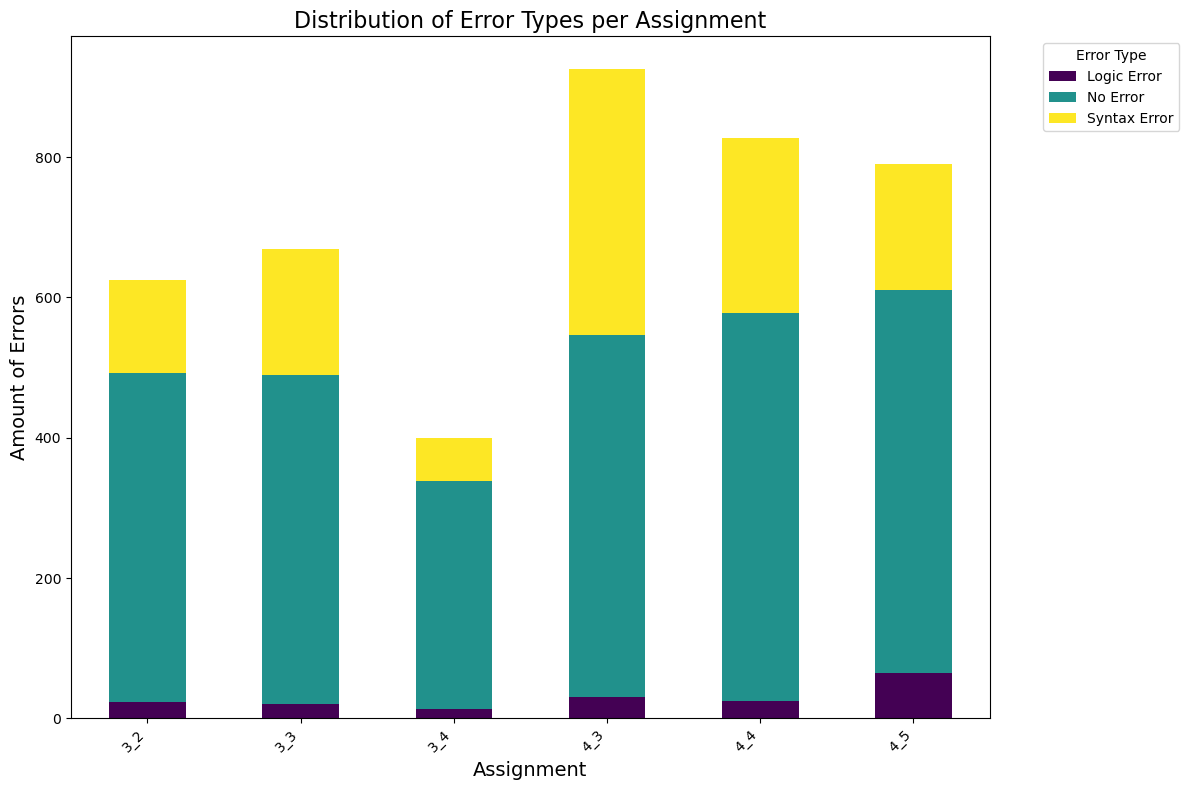

In [92]:
error_counts = queries_df.groupby(['Query Name', 'Error Type']).size().unstack(fill_value=0)

error_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')

plt.title('Distribution of Error Types per Assignment', fontsize=16)
plt.xlabel('Assignment', fontsize=14)
plt.ylabel('Amount of Errors', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Draai de x-as labels voor betere leesbaarheid
plt.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()

**Boxplot 2:**
Additionally, I have included a boxplot to provide a deeper understanding of the distribution of query executions per assignment. Each boxplot represents a specific assignment (Query Name), and the y-axis shows the number of times each query was executed by students. This visualization helps to quickly identify both general patterns and anomalies in student behavior.

To support this visual analysis, I also calculated descriptive statistics for each assignment. For example, assignment 4_5 had the highest maximum number of executions (222) and also one of the highest percentages of outliers (10%). In contrast, assignments 3_2 and 4_4 had no detected outliers, indicating more consistent performance across students. Assignment 3_3 had 4 outliers, which represents nearly 10% of all attempts for that query, pointing to a few students who may have struggled with it.

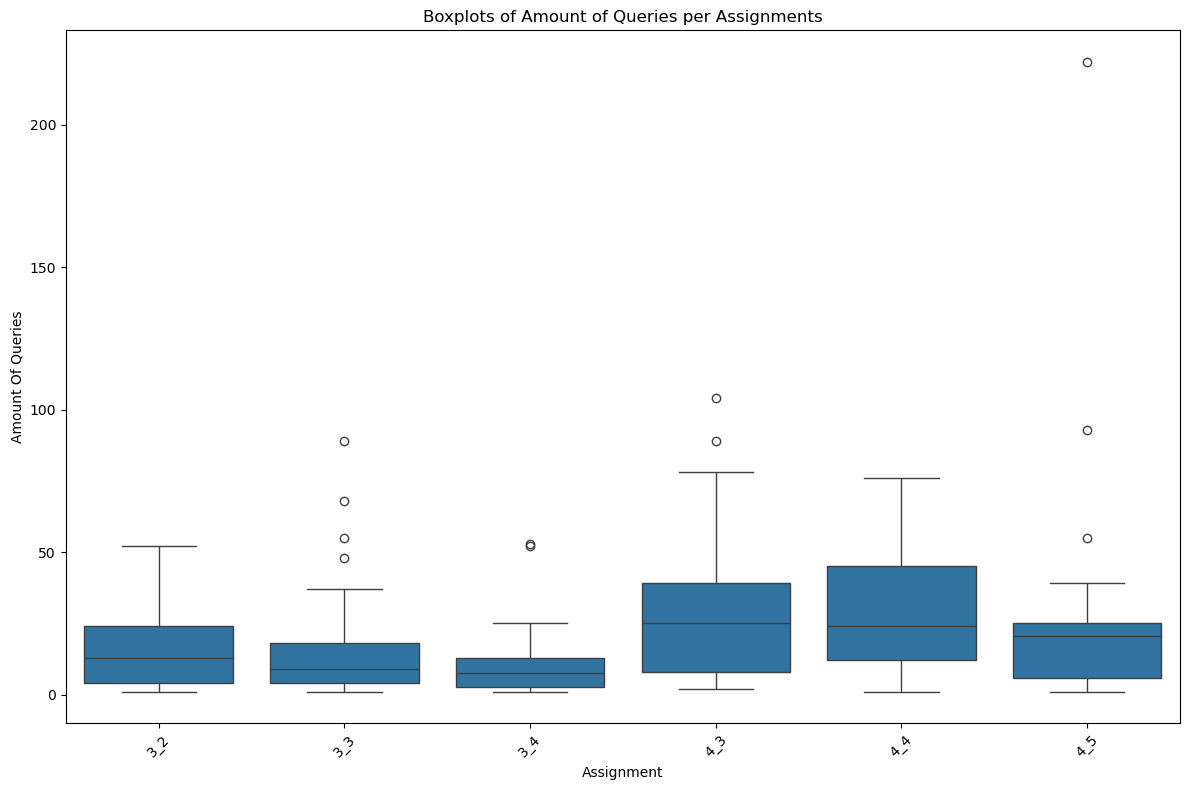

In [89]:
plt.figure(figsize=(12, 8))  
sns.boxplot(
    x='Query Name',  
    y='Amount_Of_Queries',  
    data=Query_Amount_Overview  
)
plt.title('Boxplots of Amount of Queries per Assignments')  
plt.xlabel('Assignment')  
plt.ylabel('Amount Of Queries')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [142]:
boxplot_stats = Query_Amount_Overview.groupby('Query Name')['Amount_Of_Queries'].describe()

outlier_counts = []

for query_name, group in Query_Amount_Overview.groupby('Query Name'):
    q1 = group['Amount_Of_Queries'].quantile(0.25)
    q3 = group['Amount_Of_Queries'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = group[(group['Amount_Of_Queries'] < lower_bound) | (group['Amount_Of_Queries'] > upper_bound)]
    
    outlier_counts.append({
        'Query Name': query_name,
        'Outlier Count': len(outliers),
        'Outlier %': (len(outliers) / len(group)) * 100
    })

outlier_df = pd.DataFrame(outlier_counts)

boxplot_stats = boxplot_stats.reset_index()

combined_df = pd.merge(boxplot_stats, outlier_df, on='Query Name')

combined_df = combined_df.set_index('Query Name').loc[sorted_query_names].reset_index()

pd.set_option('display.float_format', '{:.2f}'.format)
display(combined_df)


,Query Name,count,mean,std,min,25%,50%,75%,max,Outlier Count,Outlier %
0,3_2,41.00,15.24,12.95,1.00,4.00,13.00,24.00,52.00,0,0.00
1,3_3,41.00,16.32,19.27,1.00,4.00,9.00,18.00,89.00,4,9.76
2,3_4,40.00,9.97,11.80,1.00,2.75,7.50,13.00,53.00,2,5.00
3,4_3,32.00,28.94,26.40,2.00,8.00,25.00,39.25,104.00,2,6.25
4,4_4,29.00,28.52,21.01,1.00,12.00,24.00,45.00,76.00,0,0.00
5,4_5,30.00,26.33,41.42,1.00,6.00,20.50,25.00,222.00,3,10.00


In [145]:
outliers_dict = {}

for query_name, group in Query_Amount_Overview.groupby('Query Name'):
    q1 = group['Amount_Of_Queries'].quantile(0.25)
    q3 = group['Amount_Of_Queries'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = group[(group['Amount_Of_Queries'] < lower_bound) | (group['Amount_Of_Queries'] > upper_bound)]

    outliers_dict[query_name] = outliers.reset_index(drop=True)

display(outliers_dict['3_3'])


,Query Name,File,Amount_Of_Queries
0,3_3,pp1.py,55
1,3_3,pp15.py,48
2,3_3,pp41.py,68
3,3_3,pp27.py,89


To gain a deeper understanding of the relationships between different types of features in my dataset, I created a correlation matrix. This matrix provides a comprehensive overview of how each feature correlates with the others, helping me identify potential patterns, dependencies, or redundancies in the data.

The correlation matrix is particularly useful for guiding further analysis. For example, by examining the correlation coefficients, I can determine which features are strongly related and which are independent. This allows me to focus on specific relationships that may be worth exploring in more detail. Based on the insights from the correlation matrix, I can create targeted scatterplots to visualize the distribution of data points and identify any outliers or unusual patterns. These scatterplots provide a more granular view of the relationships between features, helping me to better understand the underlying structure of the data.

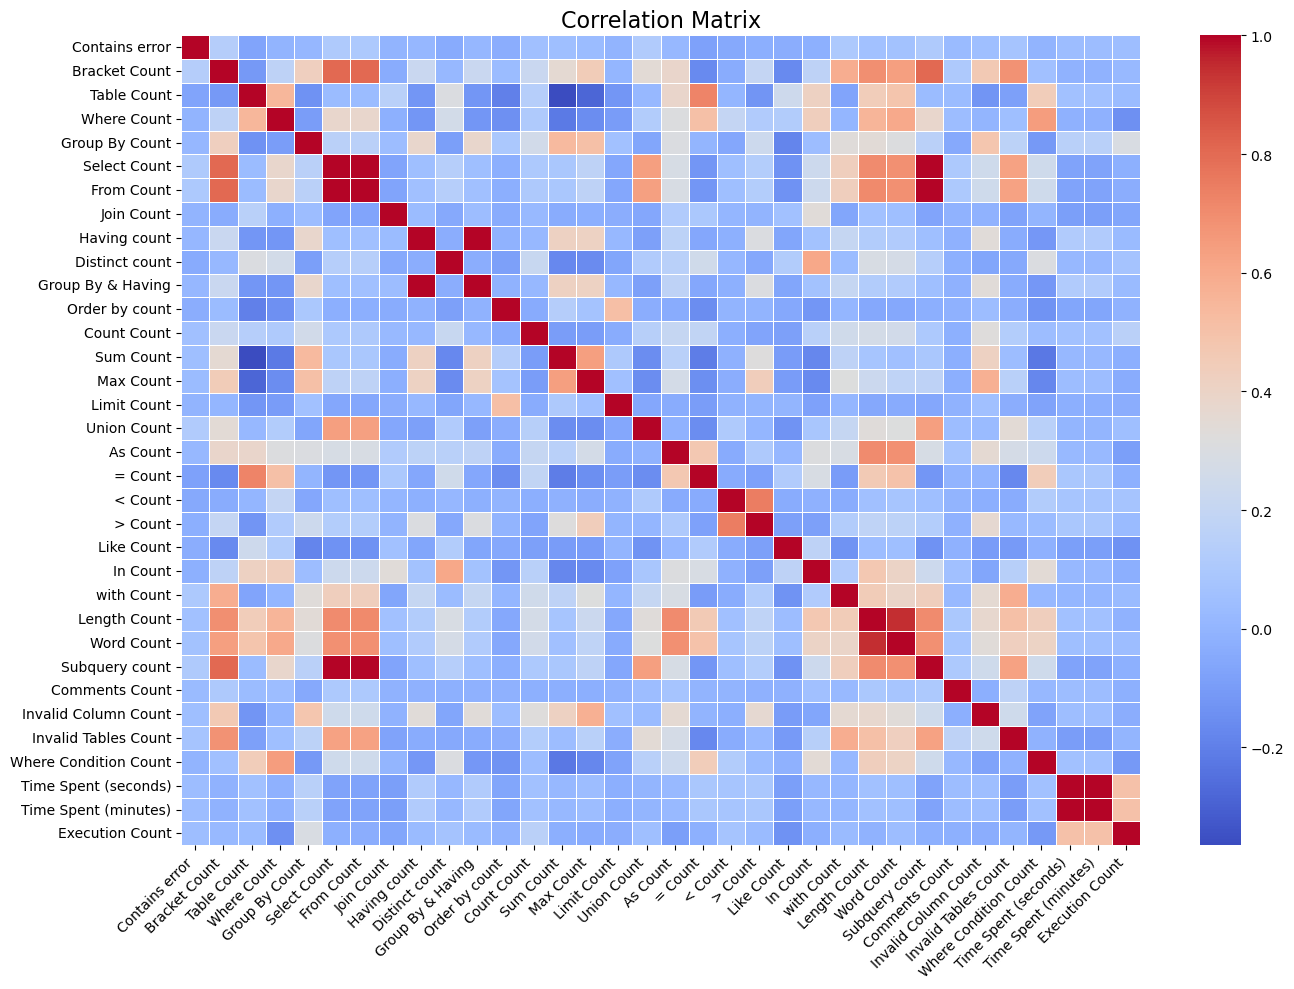

In [103]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Description of the Scatterplots:**
To understand the relationships between different variables in my dataset, I created a series of scatterplots. These visualizations help me identify patterns, trends, and outliers, which are essential. Below, I discuss each of the scatterplots and the insights they provide.
 
 1. Word Count vs Length Count: 
This scatterplot examines the relationship between the number of words (Word Count) and the total length of the query (Length Count). Overall, I observe a positive trend: queries with more words also have a greater total length. This makes sense, as more words typically result in a longer query. However, there are some outliers. Queries with a high Word Count but a low Length Count might indicate queries with many short words, while queries with a low Word Count but a high Length Count could contain many long words or special characters. These insights help me understand how the structure of the queries varies.

2. Execution Count vs Time Spent (seconds):
This scatterplot shows the relationship between the number of times a query was executed (Execution Count) and the time spent on the query (Time Spent (seconds)). I notice a slight positive trend, suggesting that queries executed more frequently generally take more time. This could indicate more complex queries that require multiple attempts. However, there are some interesting outliers. Queries with a high Execution Count but a low Time Spent (seconds) might represent queries that are executed quickly but repeated often, possibly due to errors. On the other hand, queries with a low Execution Count but a high Time Spent (seconds) could be complex queries that take a lot of time but are executed less frequently.

3. Bracket Count vs Select Count:
This scatterplot explores the relationship between the number of brackets (Bracket Count) and the number of SELECT statements (Select Count) in a query. I see a clear positive trend: queries with more SELECT statements also contain more brackets. This is likely due to the use of nested subqueries. However, there are some exceptions. Queries with a high Bracket Count but a low Select Count might indicate complex conditions in WHERE clauses, while queries with a low Bracket Count but a high Select Count could be simple queries without nested subqueries.


4. Bracket Count vs Invalid Tables Count:
This scatterplot examines the relationship between the number of brackets (Bracket Count) and the number of invalid tables (Invalid Tables Count) in a query. I observe a weak positive trend, suggesting that queries with more brackets also tend to have slightly more invalid tables. This could indicate complex queries that contain errors. However, there are some interesting outliers. Queries with a high Bracket Count but a low Invalid Tables Count might be complex but correctly written queries, while queries with a low Bracket Count but a high Invalid Tables Count could be simple queries with errors, such as incorrect table names.

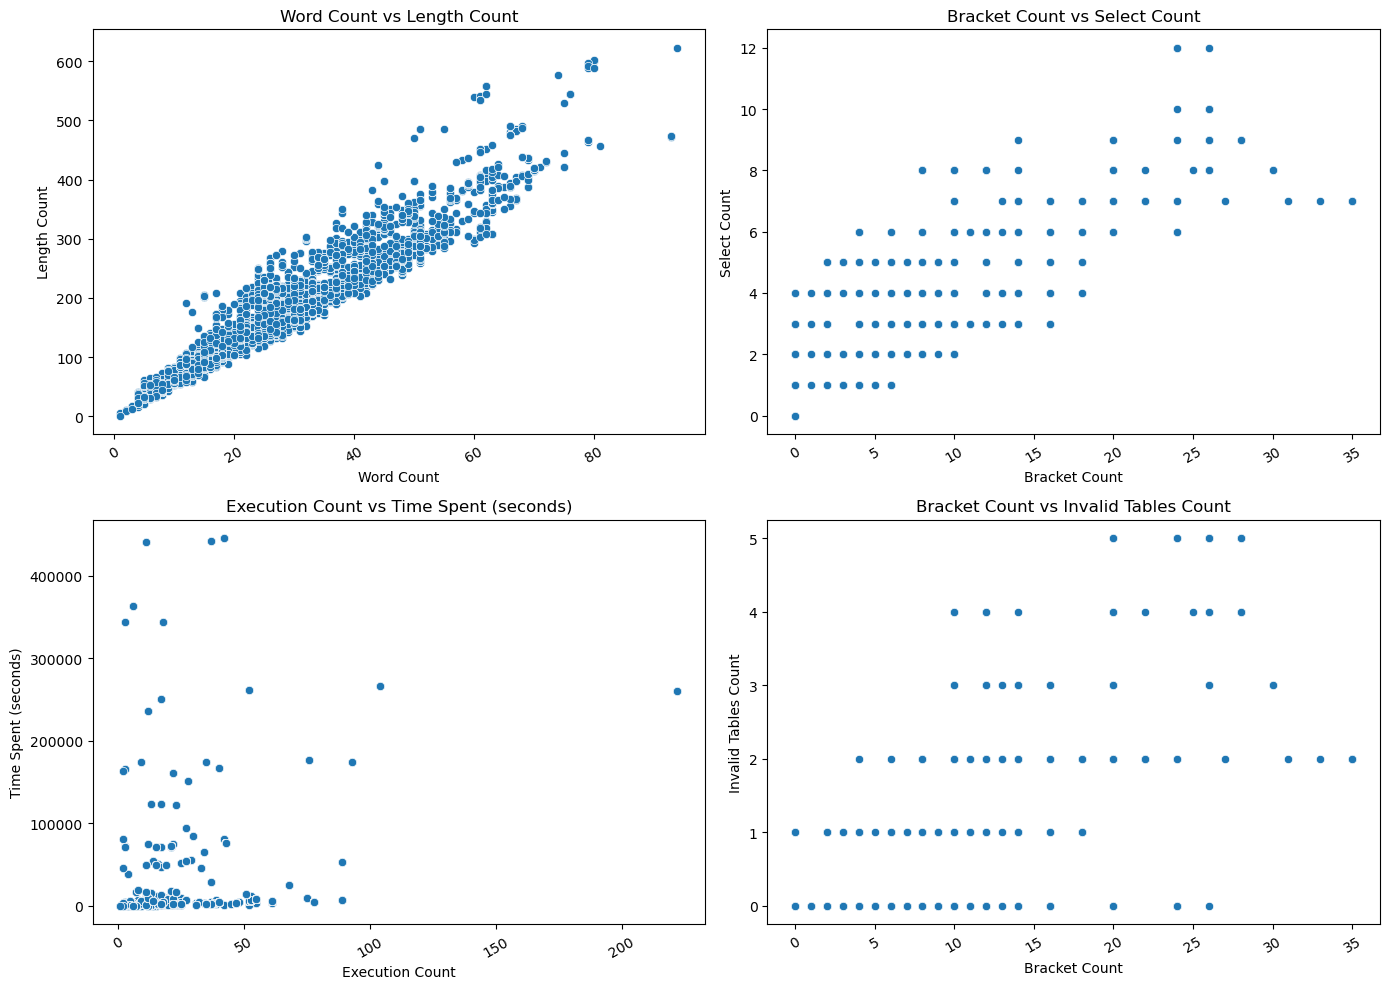

In [113]:
scatter_pairs = [
    ('Word Count', 'Length Count'),
    ('Bracket Count', 'Select Count'),
    ( 'Execution Count', 'Time Spent (seconds)'),
    ('Bracket Count', 'Invalid Tables Count')
]

# Maak een 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  

axes = axes.flatten()

for i, (x_col, y_col) in enumerate(scatter_pairs):
    sns.scatterplot(x=x_col, y=y_col, data=queries_df, ax=axes[i])
    axes[i].set_title(f'{x_col} vs {y_col}')
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


📊 Analyseren voor: No Error


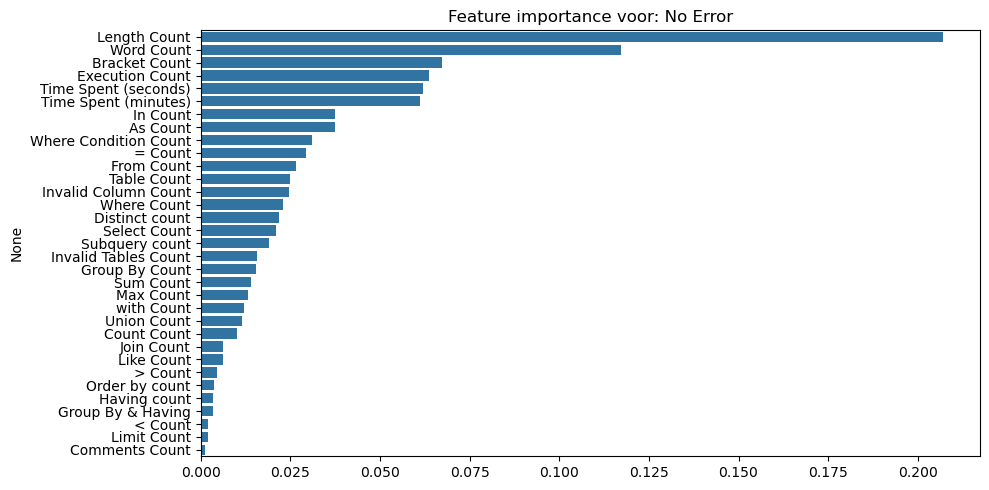


📊 Analyseren voor: Syntax Error


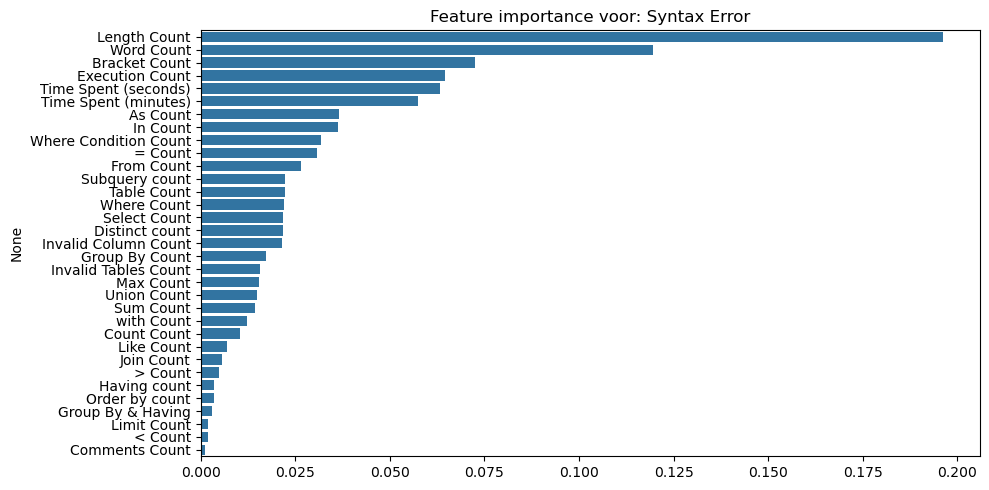


📊 Analyseren voor: Logic Error


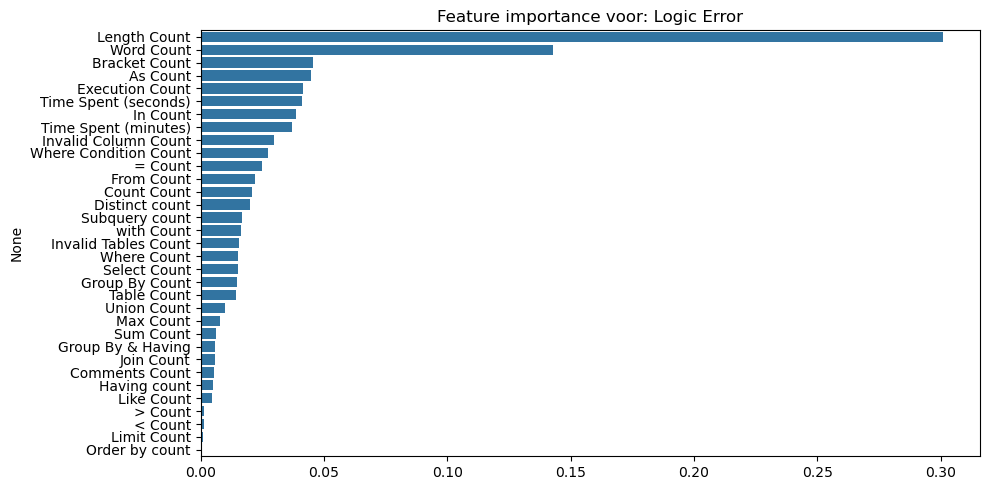

In [129]:
df = queries_df.copy()

error_types = df['Error Type'].unique()

numeric_features = df.select_dtypes(include='number').columns.tolist()
if 'Contains error' in numeric_features:
    numeric_features.remove('Contains error') 
    numeric_features.remove('Error Type Encoded')

# Resultaat opslaan
importances_per_error = {}

for error in error_types:
    print(f"\n📊 Analyseren voor: {error}")
  
    df['target'] = (df['Error Type'] == error).astype(int)
    
    X = df[numeric_features]
    y = df['target']
    
    # Model trainen
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)

    importances = model.feature_importances_
    importances_per_error[error] = dict(zip(X.columns, importances))
    
    sorted_idx = importances.argsort()[::-1]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=importances[sorted_idx], y=X.columns[sorted_idx])
    plt.title(f'Feature importance voor: {error}')
    plt.tight_layout()
    plt.show()
